In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib widget
from eitprocessing.datahandling.breath import Breath
from eitprocessing.datahandling.continuousdata import ContinuousData
from eitprocessing.datahandling.intervaldata import IntervalData
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.features.breath_detection import BreathDetection
from eitprocessing.features.pixel_inflation import PixelInflation
from eitprocessing.filters.butterworth_filters import LowPassFilter
from eitprocessing.parameters.eeli import EELI
from eitprocessing.parameters.tidal_impedance_variation import TIV

MINUTE = 60

In [ ]:
path = ...

In [2]:
sequence = load_eit_data(
    path,
    vendor="draeger",
)

In [3]:
# sequence = sequence.t[40537:40560]

In [4]:
sequence = sequence.t[55940:55970]

In [5]:
eitdata_label = "raw"
continuousdata_label = "global_impedance_(raw)"

eitdata = sequence.eit_data[eitdata_label]

breath_detection = BreathDetection(eitdata.framerate)
breaths = breath_detection.find_breaths(sequence.continuous_data[continuousdata_label])

breath_middle_indices = np.array(
    [np.argmax(eitdata.time == middle_time) for middle_time in [breath.middle_time for breath in breaths.values]],
)

_, rows, cols = eitdata.pixel_impedance.shape

pixel_inflations = np.empty((rows, cols), dtype=object)
for row in range(rows):
    for col in range(cols):
        end = []
        middle = []

        if not np.isnan(
            eitdata.pixel_impedance[:, row, col],
        ).any() and not np.all(
            eitdata.pixel_impedance[:, row, col] == 0.0,
        ):
            start = [
                np.argmin(
                    eitdata.pixel_impedance[
                        breath_middle_indices[i] : breath_middle_indices[i + 1],
                        row,
                        col,
                    ],
                )
                + breath_middle_indices[i]
                for i in range(len(breath_middle_indices) - 1)
            ]

            end = [start[i + 1] for i in range(len(start) - 1)]
            middle = [
                np.argmax(
                    eitdata.pixel_impedance[start[i] : start[i + 1], row, col],
                )
                + start[i]
                for i in range(len(start) - 1)
            ]

            time = eitdata.time

            inflations = [
                Breath(time[s], time[m], time[e])
                for s, m, e in zip(
                    start[:-1],
                    middle,
                    end,
                    strict=True,
                )
            ]
        else:
            inflations = []
        pixel_inflations[row, col] = inflations

sequence.interval_data.add(
    IntervalData(
        label="pixel_inflation",
        name="Pixel in- and deflation timing as determined by PixelInflation",
        unit=None,
        category="breath",
        intervals=[
            (time[breath_middle_indices[i]], time[breath_middle_indices[i + 1]])
            for i in range(len(breath_middle_indices) - 1)
        ],
        values=pixel_inflations,
        parameters={},
        derived_from=[eitdata],
    ),
)

pixel_inflations = sequence.interval_data["pixel_inflation"]

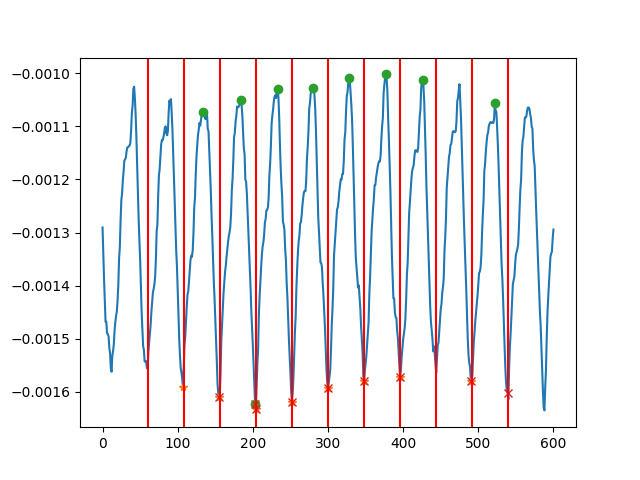

In [6]:
pixel_data = sequence.eit_data["raw"].pixel_impedance

start_indices = [
    np.argmax(sequence.eit_data["raw"].time == start_time)
    for start_time in [pixel_inflation.start_time for pixel_inflation in pixel_inflations.values[0, 3]]
]
middle_indices = [
    np.argmax(sequence.eit_data["raw"].time == middle_time)
    for middle_time in [pixel_inflation.middle_time for pixel_inflation in pixel_inflations.values[0, 3]]
]
end_indices = [
    np.argmax(sequence.eit_data["raw"].time == end_time)
    for end_time in [pixel_inflation.end_time for pixel_inflation in pixel_inflations.values[0, 3]]
]


plt.figure()
plt.plot(pixel_data[:, 0, 3])
plt.plot(start_indices, pixel_data[start_indices, 0, 3], "*")
plt.plot(middle_indices, pixel_data[middle_indices, 0, 3], "o")
plt.plot(end_indices, pixel_data[end_indices, 0, 3], "x")
for i in range(len(breath_middle_indices)):
    plt.axvline(breath_middle_indices[i], color="red")